# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:
* Use modified sampling techniques to address class imbalance problems
* Understand the complications of class imbalance problems

## Predicting Credit Card Fraud
Load the **creditcard.csv.gz** file and preview the data. To load a compressed csv, use the optional parameter `compression='gzip'` within pandas read_csv method as in: `pd.read_csv(filename, compression='gzip')`.

In [14]:
#Your code here
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

In [2]:
df = pd.read_csv('creditcard.csv.gz', compression='gzip')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preview the class imbalance

You should see that the dataset has 31 columns. The first is a time field followed by V1-V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary Class flag. This last column, Class, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is.

In [5]:
# value counts for Class column, our y
y = df.Class
print(y.value_counts())
print(y.value_counts(normalize=True))

0    284315
1       492
Name: Class, dtype: int64
0    0.998273
1    0.001727
Name: Class, dtype: float64


## Define the Problem

Define X and y and perform a standard train test split.

In [10]:
# Define X, y is already defined above
X = df[df.columns[:-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [13]:
print("Train value counts:\n", y_train.value_counts())
print("Test value counts:\n", y_test.value_counts())

Train value counts:
 0    213233
1       372
Name: Class, dtype: int64
Test value counts:
 0    71082
1      120
Name: Class, dtype: int64


## Create an initial model

As a baseline, fit a cookie cutter out of the box logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC: 0.8841414375885128


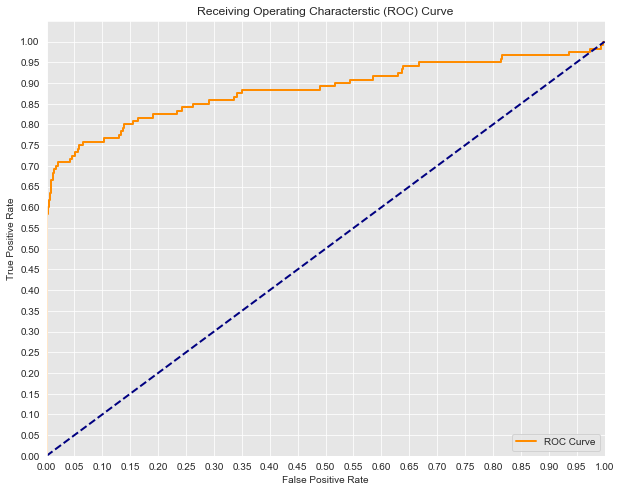

In [15]:
# Initialize a baseline model
logreg = LogisticRegression(fit_intercept = False,solver='liblinear')
baseline_model = logreg.fit(X_train, y_train)
print(baseline_model)

#Probability scores for the test set
y_score = baseline_model.decision_function(X_test)

#FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curves
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color="darkorange",
        lw=lw, label="ROC Curve")
plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiving Operating Characterstic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                         title="Confusion Matrix", 
                         cmap=plt.cm.Blues):
    #Add Normalization option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center", 
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

Confusion Matrix, without normalization
[[71026    53]
 [   56    67]]


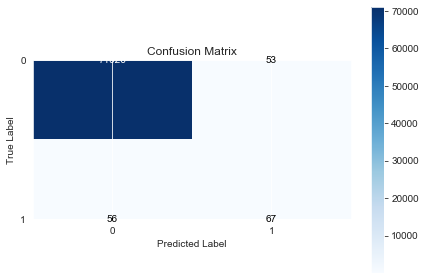

In [22]:
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

## Tuning 
Try some of the various techniques proposed to tune your model. Compare your models using AUC, ROC or another metric.

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.8397641690817178
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.8817812526377986
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear

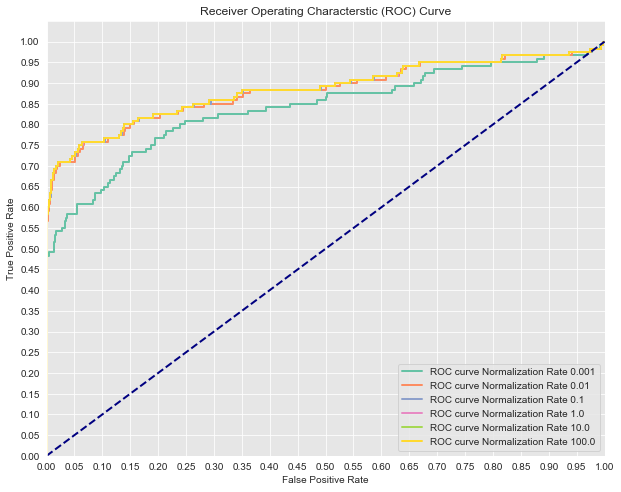

In [25]:
#Adjusting the C Parameter in the LogisitcRegression arguments
C_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
names = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept=False, C = c, solver="liblinear")
    model_log = logreg.fit(X_train, y_train)
    print(model_log)
    
    #Predict
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print("AUC for {}: {}".format(names[n], auc(fpr, tpr)))
    lw = lw
    plt.plot(fpr, tpr, color=colors[n], 
            lw=lw, label="ROC curve Normalization Rate {}".format(names[n]))

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks([i/20.0 for i in range(21)])
plt.yticks([i/20.0 for i in range(21)])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characterstic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
    

Confusion Matrix, without normalization
[[71026    53]
 [   56    67]]


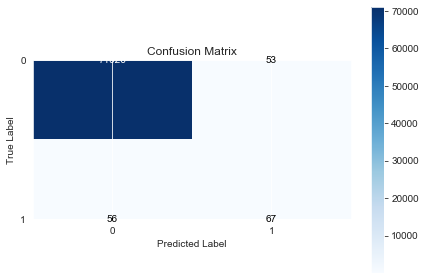

In [27]:
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

### SMOTE
If you haven't already, try using the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

In [26]:
#Your code here
print(y.value_counts()) # Previous original class distributions
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
print(pd.Series(y_train_resampled).value_counts()) # to preview the synthetic sample class distributions

0    284315
1       492
Name: Class, dtype: int64
1    213233
0    213233
dtype: int64


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.962710554945931
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.9626927351509524
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', 

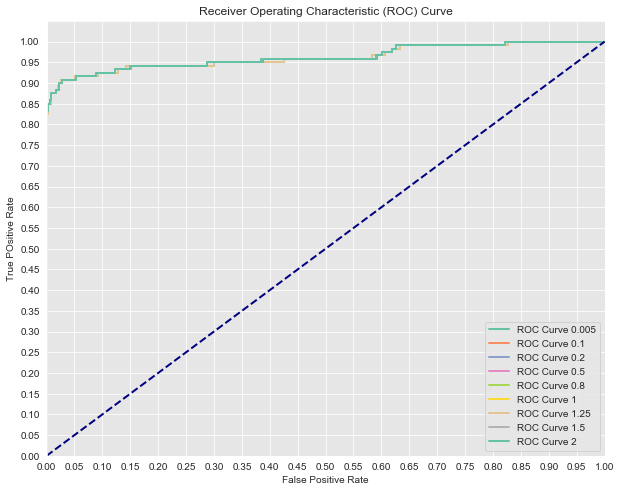

In [28]:
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)
    
    #Predict
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n], lw=lw, label="ROC Curve {}".format(names[n]))

plt.plot([0,1],[0,1], color="navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks([i/20.0 for i in range(21)])
plt.yticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True POsitive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Analysis
Describe what is misleading about the AUC score and ROC curves produced by this code:

0    284315
1       492
Name: Class, dtype: int64
1    284315
0    284315
dtype: int64
LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.992261982457822
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.9922559800919245
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn'

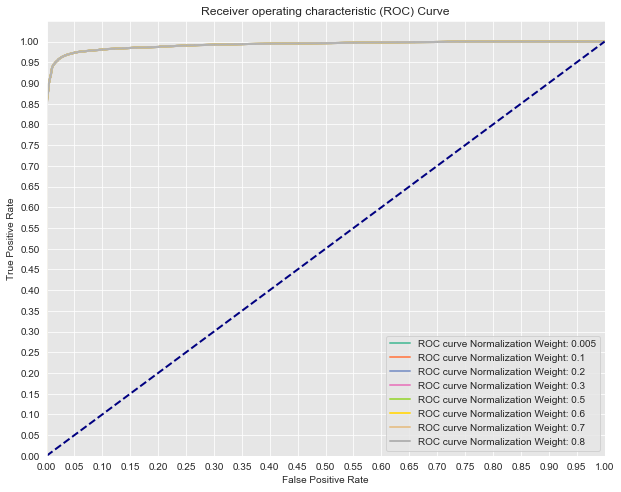

In [14]:
print(y.value_counts()) #Previous original class distribution
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c, solver='liblinear') #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Your response here

This is misleading because SMOTE should only be applied to training sets, and from there choosing an accurate gauge for the model's performance by using a raw test sample that has not already been over or undersampled. But in this case, we synthethically created test cases, meaning the test set was already manipulated by SMOTE. The results produced cannot be compared to future cases.

## Summary

In this lab, you got some hands-on practice tuning logistic regression models using various techniques and parameters. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.